In [50]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
import os
import tarfile
import urllib

In [4]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Load housing dataset tarball to disk and extract to CSV file"""

    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()

# Step 1: Data Exploration and Train-Test Split
The model we will be training will be able to predict the median house value of a given district with attributes such as longitude, latitude, median income, population, etc. A district is a small area with a population ranging anywhere from about 600 to 3000 people. The data we will be using comes from the 1990 California census. 

In [5]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

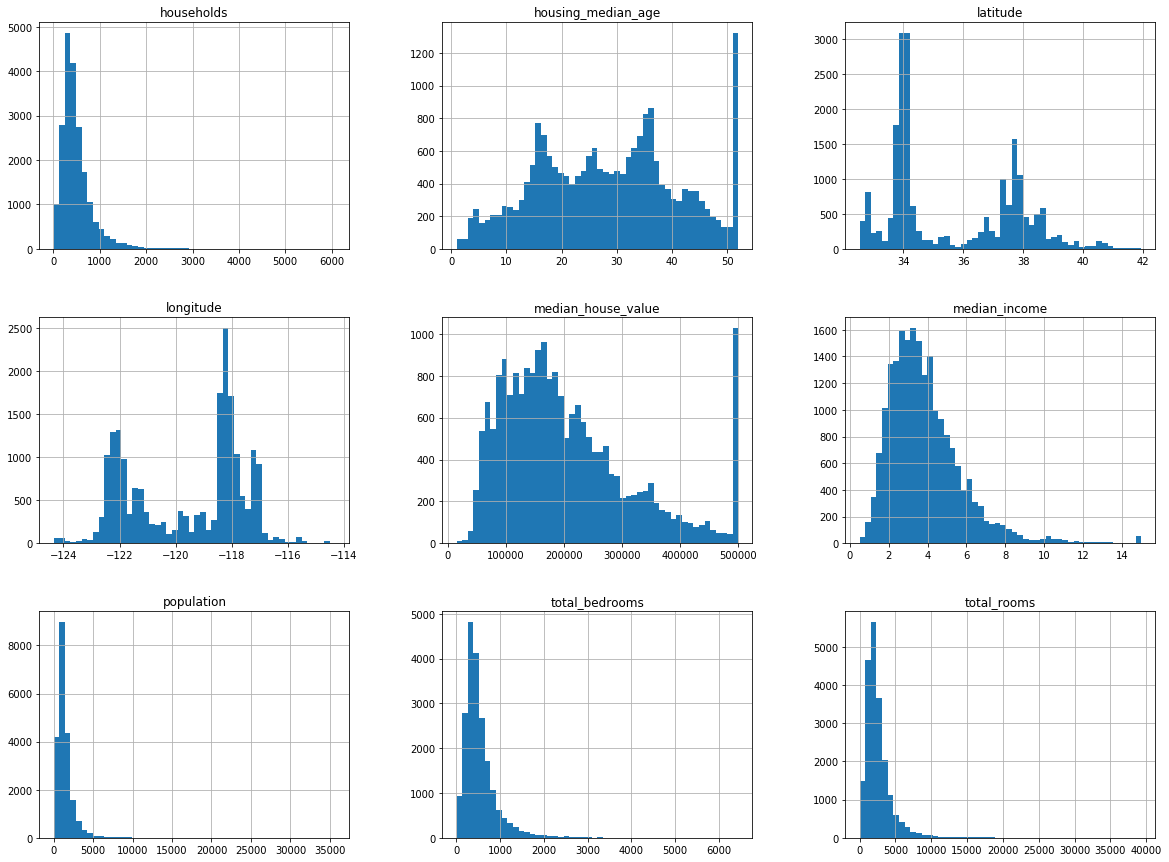

In [10]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
# train-test-split random sample (80/20)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

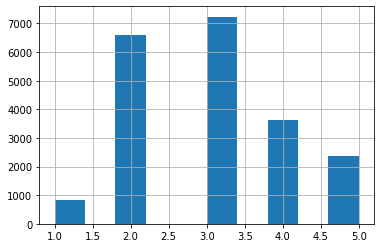

In [12]:
# split median income into categories
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [13]:
# train-test-split stratified sample by income range
# i.e. the number of instances from each income range in the test set is proportional 
# to the full dataset to guarantee that the test set is representative of the overall population
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# get proportion of each income category in the test set (can compare with full dataset to confirm)
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [14]:
# income_cat column not important anymore, drop so it's not considered in predictions
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

In [15]:
# create a copy of the training set for exploration
housing = strat_train_set.copy()

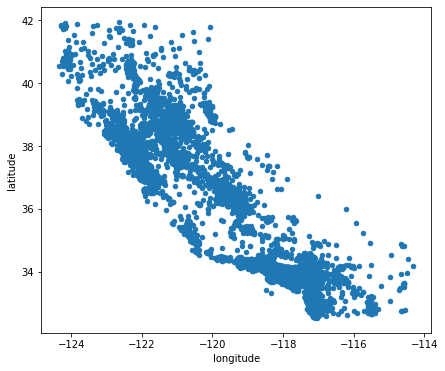

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(7,6))

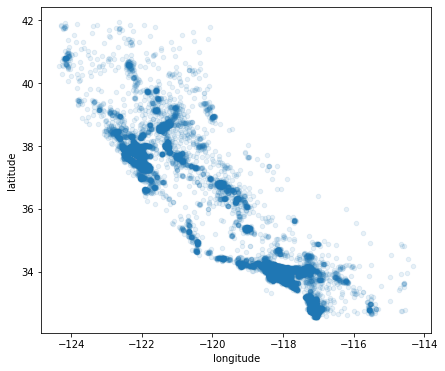

In [17]:
# options: alpha = circle opacity
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(7,6))

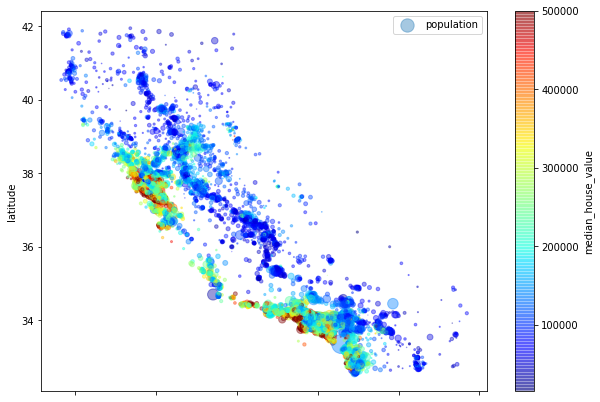

In [18]:
# options: s = circle radius, c = circle color, cmap = color scheme
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    c="median_house_value", s=housing["population"]/100, label="population",
    figsize=(10,7), cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [19]:
# standard *linear* correlation coefficient between every pair of attributes
corr_matrix = housing.corr()

# *linear* correlations between each attribute and the median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

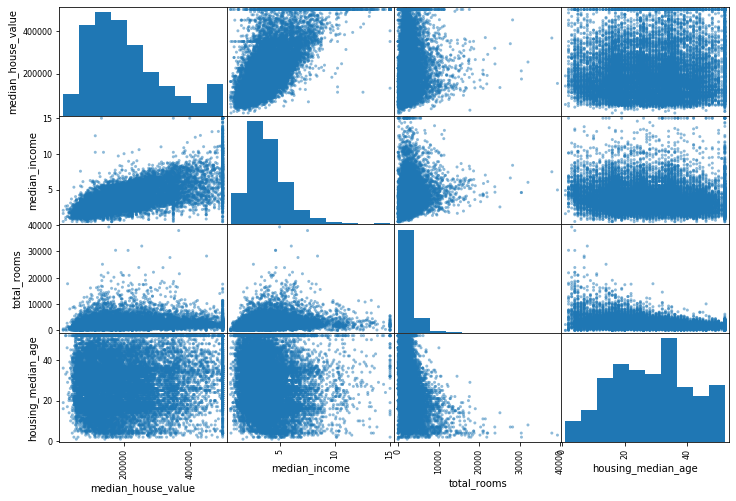

In [20]:
# get correlation scatter plot between every numerical attribute
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

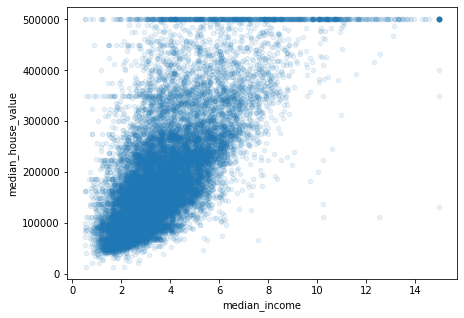

In [21]:
# the most promising attribute to predict the median house value is the median
# income, so let’s zoom in on their correlation scatterplot
housing.plot(kind="scatter", x="median_income", y="median_house_value", 
             alpha=0.1, figsize=(7,5))

In [22]:
# add important attribute combinations
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
housing["rooms_per_person"] = housing["total_rooms"] / housing["population"]

In [23]:
# check median house value correlation for new attributes
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_person            0.199429
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Step 2: Data Preparation

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [25]:
# Revert to a clean copy of the training set, and separate target variable (aka labels)
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## 2.1: Data Cleaning and Imputation

In [26]:
# Impute missing values to the median
imputer = SimpleImputer(strategy="median")
housing_numeric = housing.drop("ocean_proximity", axis=1)  # drop text column

# compute the median of each numeric attribute
imputer.fit(housing_numeric)

# replace the missing values
X = imputer.transform(housing_numeric)
housing_tr = pd.DataFrame(X, columns=housing_numeric.columns,
                          index=housing_numeric.index)

## 2.2: Encoding Text and Categorical Attributes

In [27]:
# Convert text categorical attribute to ordinal values (numbers)
ordinal_encoder = OrdinalEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [28]:
# A better categorical attribute encoder is a *one-hot encoder*
# This means creating a new attribute for every category which can take either 1 or 0
# as values to indicate if an instance is in that category. 
# This is better than the last approach of having only one column and taking a range of 
# values (ex: 0,1,...,n) to represent each category so that the ML algo doesn't assume
# that two nearby values are more similar than two distant values.

onehot_encoder = OneHotEncoder()
housing_cat_1hot = onehot_encoder.fit_transform(housing_cat)

**Tip:** If a categorical attribute has a large number of possible categories (ex: country code,
profession, species), then one-hot encoding will result in a large number of input features.
This may slow down training and degrade performance. If this happens, you may want to
replace the categorical input with useful numerical features related to the categories: for
example, you could replace the ocean_proximity feature with the distance to the ocean
(similarly, a country code could be replaced with the country’s population and GDP per
capita). Alternatively, you could replace each category with a learnable, low-dimensional
vector called an embedding

## 2.3: Custom Transformers

In [29]:
# Building a *custom transformer* for adding attributes to the dataset
# This is important for automating transformations and adding hyperparameters
# to easily gate data preparation steps in an sklearn pipeline

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        # X is the NumPy representation of the training set dataframe
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            # concatenate the new attributes with X
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## 2.4: Feature Scaling
Machine Learning algorithms generally don’t
perform well when numerical attributes have very different scales. The two common ways to get around this issue are:
- **Min-max scaling (aka Normalization):** values
are shifted and rescaled so that they end up ranging from **0 to 1**
- **Standardization:** does not bound values to a specific range, but produces a distribution of **unit variance**. Therefore, standardization is much less affected by
outliers

## 2.5: Transformation Pipelines
Define a sequence of data preparation steps that are either pre-made or custom transformation classes.

In [30]:
# Sklearn pipeline for numeric attributes
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()), # feature scaling (2.4)
])
housing_numeric_tr = numeric_pipeline.fit_transform(housing_numeric)

In [65]:
# Full pipeline including categorical attributes
numeric_attribs = list(housing_numeric)
cat_attribs = ["ocean_proximity"]

# ColumnTransformer is like Pipeline, but it also takes a third parameter specifying which
# attributes to apply the transformations to (useful when there are different types of attributes)
full_pipeline = ColumnTransformer([
    ("num", numeric_pipeline, numeric_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

# Step 3: Model Selection and Training

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

## 3.1: Linear Regression

In [33]:
# training a Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
# measure the model's RMSE on the whole training set
housing_predictions = lin_reg.predict(housing_prepared)
lin_reg_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_reg_mse)

print(f"Prediction Error: ${int(lin_rmse)}")

Prediction Error: $68628


## 3.2: Decision Tree Regressor

In [79]:
# training a Decision Tree model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [80]:
# measure the model's RMSE on the whole training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print(f"Prediction Error: ${int(tree_rmse)}")

Prediction Error: $0


## 3.4: Random Forest Regressor

In [81]:
# training a Random Forest model
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [82]:
# measure the model's RMSE on the whole training set
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print(f"Prediction Error: ${int(forest_rmse)}")

Prediction Error: $22290


## 3.5: Support Vector Machine Regressor

In [84]:
# training an SVM model
svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [85]:
# measure the model's RMSE on the whole training set
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)

print(f"Prediction Error: ${int(svm_rmse)}")

Prediction Error: $118577


## 3.6: Cross-Validation
A better way to evaluate the Decision Tree model would be to split the training set into a smaller training set and a validation set, then train the model against the smaller training set and evaluate it against the validation set.

An easy way to do this is to use **Scikit-Learn’s K-fold cross-validation** feature. The following code randomly splits the training set into 10 distinct subsets called *folds*, then it trains and evaluates the model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [87]:
# expects a utility function (greater is better) rather than a cost function (lower is better), 
# so the scoring function is actually the negative MSE
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

print("Decision Tree RMSE's:", list(tree_rmse_scores))
print("Decision Tree RMSE Mean:", tree_rmse_scores.mean())
print("Decision Tree RMSE Std. Deviation:", tree_rmse_scores.std())

Decision Tree RMSE's: [67374.18625591324, 65293.60843132853, 72139.12720522867, 69006.50449620657, 71044.53043997193, 74403.52650208658, 71359.30343913111, 71875.26507038578, 77641.89956344909, 70964.58919834344]
Decision Tree RMSE Mean: 71110.2540602045
Decision Tree RMSE Std. Deviation: 3278.0596826225105


In [48]:
# cross-validate LinReg model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

print("LinReg RMSE's:", list(lin_rmse_scores))
print("LinReg RMSE Mean:", lin_rmse_scores.mean())
print("LinReg RMSE Std. Deviation:", lin_rmse_scores.std())

LinReg RMSE's: [66782.73843989318, 66960.1180710006, 70347.95244419387, 74739.5705255179, 68031.13388937665, 71193.84183425657, 64969.63056405337, 68281.61137997014, 71552.91566557658, 67665.10082066947]
LinReg RMSE Mean: 69052.46136345083
LinReg RMSE Std. Deviation: 2731.674001798349


In [52]:
# cross-validate Random Forest model
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Random Forest RMSE's:", list(forest_rmse_scores))
print("Random Forest RMSE Mean:", forest_rmse_scores.mean())
print("Random Forest RMSE Std. Deviation:", forest_rmse_scores.std())

Random Forest RMSE's: [50903.55164651148, 49840.53976889933, 53701.959612950355, 53620.853914317864, 51920.91494947472, 55025.49876470685, 51996.56152769834, 50860.57822664796, 55828.86366120143, 52463.17876197806]
Random Forest RMSE Mean: 52616.25008343863
Random Forest RMSE Std. Deviation: 1814.5132208562577


In [86]:
# cross-validate SVM model
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)

print("SVM RMSE's:", list(svm_rmse_scores))
print("SVM RMSE Mean:", svm_rmse_scores.mean())
print("SVM RMSE Std. Deviation:", svm_rmse_scores.std())

SVM RMSE's: [111393.33263236606, 119546.71049752545, 116961.00489444671, 120449.01559739833, 117622.20149716499, 122303.76986817672, 117640.09907103027, 121459.63518806451, 120348.5136451926, 118025.61954959406]
SVM RMSE Mean: 118574.99024409598
SVM RMSE Std. Deviation: 2934.1329433145675


- Linear Regression model is **underfitting** the training data
 - Training set prediction error: ~\$68,000
 - Cross-Validation prediction error: ~\$69,000


- Decision Tree model is **overfitting** the training data
 - Training set prediction error: \$0
 - Cross-Validation prediction error: ~\$71,000


- Random Forest model is **overfitting** the training data
 - Training set prediction error: ~\$18,000
 - Cross-Validation prediction error: ~\$52,000
 

- Support Vector Machine model is **underfitting** the training data
 - Training set prediction error: ~\$118,000
 - Cross-Validation prediction error: ~\$118,000

# Step 4: Fine-Tuning and Testing the Models
You can fiddle with hyperparameters manually, until you
find a great combination of hyperparameter values, but this would be very tedious work. You will also probably not be able to explore all combinations by hand.

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

## 4.1: Grid Search
Try all combinations of hyperparameters to find the best one.

#### Grid Search on Random Forest

In [64]:
# try all combinations of hyperparameters specified in the dicts
param_grid = [
    {'n_estimators': [20, 30, 40, 60], 'max_features': [2, 4, 6, 8, 10]}, # 4x5 = 20 combinations
    {'bootstrap': [False], 'n_estimators': [100, 120, 140, 160], 'max_features': [5, 6, 7]}, # 1x4x3 = 12 combinations
]
forest_reg = RandomForestRegressor()

# 32 hyperparam combinations x 5 cross-validation folds = 155 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'bootstrap': [False], 'max_fea

In [66]:
# get the best hyperparameters
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 160}

In [67]:
# get the best model directly
tuned_forest_reg = grid_search.best_estimator_

In [68]:
# get evaluation scores for all hyperparameter combinations
results = grid_search.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(np.sqrt(-mean_score), params)

48399.628129040175 {'bootstrap': False, 'max_features': 5, 'n_estimators': 100}
48388.330731406604 {'bootstrap': False, 'max_features': 5, 'n_estimators': 120}
48360.75879122073 {'bootstrap': False, 'max_features': 5, 'n_estimators': 140}
48356.830931460485 {'bootstrap': False, 'max_features': 5, 'n_estimators': 160}
48547.04931647189 {'bootstrap': False, 'max_features': 6, 'n_estimators': 100}
48354.4309700814 {'bootstrap': False, 'max_features': 6, 'n_estimators': 120}
48334.88818999584 {'bootstrap': False, 'max_features': 6, 'n_estimators': 140}
48317.49995983493 {'bootstrap': False, 'max_features': 6, 'n_estimators': 160}
48518.35879261125 {'bootstrap': False, 'max_features': 7, 'n_estimators': 100}
48464.7766403942 {'bootstrap': False, 'max_features': 7, 'n_estimators': 120}
48585.18904598198 {'bootstrap': False, 'max_features': 7, 'n_estimators': 140}
48459.27097335193 {'bootstrap': False, 'max_features': 7, 'n_estimators': 160}


#### Grid Search on Support Vector Machine

In [100]:
param_grid = [
    {'kernel': ["linear"], 'C': [1000, 10000, 100000]},
]
svm_reg = SVR()

grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1000, 10000, 100000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [101]:
grid_search.best_params_

{'C': 100000, 'kernel': 'linear'}

In [102]:
# get evaluation scores for all hyperparameter combinations
results = grid_search.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(np.sqrt(-mean_score), params)

70445.41077712944 {'C': 1000, 'kernel': 'linear'}
70374.82796803635 {'C': 10000, 'kernel': 'linear'}
70352.61867210406 {'C': 100000, 'kernel': 'linear'}


## 4.2: Randomized Search
The grid search approach is fine when you are exploring relatively **few** combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. Instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
- If you let the randomized search run for, say, 1000 iterations, this approach will explore 1000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).
- Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

In [105]:
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, 
                                scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [107]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [106]:
results = rnd_search.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


## 4.3: Analyzing Models and Feature Importance
You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions. This is an important step in the iteration process because you can go back and **retrain** the model **without using the unpredictive features**.

In [69]:
# get feature importances (i.e. how much each feature contributes to the predictions)
feature_importances = tuned_forest_reg.feature_importances_

extra_attribs = ["rooms_per_household", "pop_per_household", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = numeric_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.3200879181638851, 'median_income'),
 (0.1513647383243041, 'INLAND'),
 (0.10842998144650051, 'pop_per_household'),
 (0.08148162813227627, 'longitude'),
 (0.07678440747694133, 'bedrooms_per_room'),
 (0.07251811715890863, 'latitude'),
 (0.06110354960731574, 'rooms_per_household'),
 (0.04217640361419762, 'housing_median_age'),
 (0.01709680270636965, 'total_rooms'),
 (0.01703675729188606, 'population'),
 (0.015936745912252248, 'total_bedrooms'),
 (0.015241730822038325, 'households'),
 (0.012931302730454208, '<1H OCEAN'),
 (0.00475661479572769, 'NEAR OCEAN'),
 (0.0029612621922247328, 'NEAR BAY'),
 (9.203962471779687e-05, 'ISLAND')]

## 4.4: Evaluate the Model on the Test Set
Don't forget to call transform(), not fit_transform() - you do not want to fit the test set!

In [108]:
# full pipeline with both data preparation and prediction
full_pipeline_with_predictor = Pipeline([
    ("preparation", full_pipeline),
    ("regression", tuned_forest_reg)
])

In [109]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = full_pipeline_with_predictor.predict(X_test)

# you could also separately transform the data and then pass it to the model's predict() function
# X_test_prepared = full_pipeline.transform(X_test)
# final_predictions = tuned_forest_reg.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f"RMSE on test set: ${int(final_rmse)}")

RMSE on test set: $46324


## That's It!
Now you have a trained and tuned model ready for production. Whenever you want to use the model to make predictions on new data, all you have to do is call the predict() function passing in the prepared data, and the model will return the labels.

You can **deploy** the model either by A) inserting it directly in your backend code (if written in Python), B) using it as a web service with something like AWS Lambda, or C) by uploading it to a self-provisioning ML web service platform like Google Cloud AI Platform (recommended). The last option is great because it abstracts away a lot of the DevOps work like load balancing and scaling.

# Future Considerations
Deployment is not the end of the story. You also need to write **monitoring** code to check your system’s live performance at regular intervals and trigger alerts when it drops. This could be a gentle decay that could easily go unnoticed for a long time. This is quite common because models tend to **“rot”** over time. 

Depending on the kind of model you have, it may not be very straightforward to actually determine the performance (e.g., image classification) unless a **human verifies** the results. You can use crowdsourcing services (like AWS Mechanical Turk) to automate this process.

If the data keeps **evolving**, you will need to update your datasets and retrain your model regularly. Here are a few things you can automate:
- Collect fresh data regularly and label it (e.g., using human raters)
- Write a script to train the model and fine-tune the hyperparameters automatically. This script could run automatically, for example every day or every week, depending on your needs.
- Write another script that will evaluate both the new model and the previous model on the updated test set, and deploy the model to production if the performance has not decreased (if it did, make sure you investigate why).

You should also make sure you evaluate the quality of the **input data** (e.g., by comparing it with the training set), and check if there are any bugs at any stage in your **data pipeline** which affect the quality of intermediate outputs.

Finally, make sure you keep **backups** of every model you create and have the process and tools in place to roll back to a previous model quickly. You should also keep backups of every version of your datasets if a new one ever gets corrupted.